In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import jax
import jax.numpy as jnp
from tinyjaxley.modules.comp import Compartment
from tinyjaxley.modules.branch import Branch
from tinyjaxley.modules.cell import Cell
from tinyjaxley.channels.hh import Na, K, Leak
import matplotlib.pyplot as plt
from tinyjaxley.solvers import fw_euler
import pandas as pd
from diffrax import diffeqsolve, ODETerm, SaveAt, Dopri5

- recurse into channels (comp, submodules?) (and vectorfield?)
- use continues stimuli? interpolate?

In [128]:
comp = Compartment()
comp.record("v")
comp.add(Leak())
comp.add(Na())
comp.add(K())
comp.stimulate(lambda t, u: 0.01)

t0 = 0
p = comp.params
comp.set("v", -60.0)
u0 = comp.init(t0, comp.states, comp.params)

In [131]:
def vectorfield(t, u, p):
    for key, ext in comp.externals.items():
        u[key] =  sum(f(t, u) for f in ext)

    du = {"i": comp.i(t, u, p)}
    for cname, channel in comp.channels.items():
        du[cname] = channel(t, u[cname], (p[cname], u["v"]))
    
    i_c = 0.0
    for cname in comp._channels:
        i_c += du[cname]["i"] * 1000.0 # mA/cm² -> μA/cm².
    du["v"] = (du["i"] - i_c) / p["c"]
    return du

ode = ODETerm(vectorfield)
tspan = (0, 20)
ts = jnp.arange(*tspan, 0.025)
saveat = SaveAt(ts = ts)
sol = diffeqsolve(ode, Dopri5(), *tspan, y0 = u0, dt0 = 0.025, saveat = saveat, args = p)

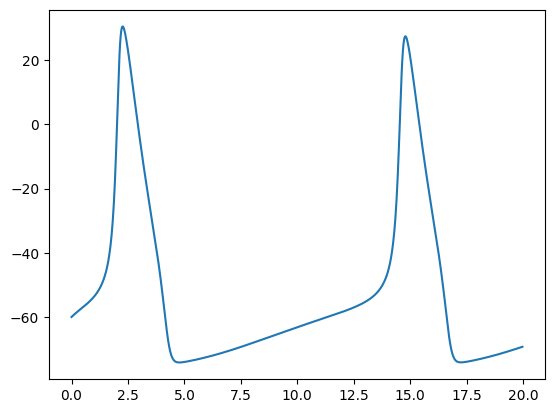

In [132]:
plt.plot(sol.ts, sol.ys["v"])